In [522]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [523]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploration

In [969]:
from baseline import Baseline

In [970]:
from genhebb import HebbianLayer, GenHebb

In [971]:
from learning_rules import learning_rules

ImportError: cannot import name 'learning_rules' from 'learning_rules' (/Users/cutterdawes/Desktop/MPI/HebbianLearning/learning_rules.py)

In [972]:
from sklearn.decomposition import PCA

### Investigate unsup layer weight matrix

In [644]:
!pwd

/Users/cutterdawes/Desktop/MPI/HebbianLearning


In [691]:
def load_model(learning_rule=None, unsup_epochs=50, model_name=None, mid_training=False, epoch=None):
    directory = 'saved_models/mid-training' if mid_training else 'saved_models/done-training'
    if not model_name:
        model_name = f'genhebb-{learning_rule}-{unsup_epochs}_unsup_epochs-50_sup_epochs-0.001_unsup_lr-0.001_sup_lr-64_batch'
    if mid_training:
        model_name += f'-epoch_{epoch}'
    path = f'{directory}/{model_name}.pt'
    if model_name.split('-')[0] == 'genhebb':
        model = GenHebb(28*28, 2000, 10, learning_rule)
    else:
        model = Baseline(28*28, 2000, 10)
    model.load_state_dict(torch.load(path))
    return model

In [678]:
def load_data(sample_size=1000):
    trainset = FastMNIST('./data', train=True, download=True)
    images, labels = next(iter(DataLoader(trainset, batch_size=sample_size, shuffle=True)))
    x = images.reshape(-1, 28*28)
    return x, labels

In [731]:
def get_projection(x):
    pca = PCA(n_components=2)
    x_proj = pca.fit_transform(x)
    x_expl_var = pca.explained_variance_ratio_
    x_expl_var = [round(var, 3) for var in x_expl_var]
    return x_proj, x_expl_var

In [732]:
# load original data and get projection
x, labels = load_data(sample_size=1000)
x_proj, x_expl_var = get_projection(x)

In [733]:
# get projections for all hebbian-learned embeddings
proj_embeddings = {}
expl_vars = {}

for learning_rule in ['hard_WTA_ojas_rule', 'ojas_rule', 'hebbs_rule']:
    for unsup_epochs in [1, 5, 10, 50]:

        # get projected embedding
        model = load_model(learning_rule, unsup_epochs=unsup_epochs)
        Wx = model.unsup_layer(x).detach()
        Wx_proj, Wx_expl_var = get_projection(Wx)

        # add to dicts
        key = f'{learning_rule}-{unsup_epochs}'
        proj_embeddings[key] = Wx_proj
        expl_vars[key] = Wx_expl_var
        print(f'Done for {key}')

Done for hard_WTA_ojas_rule-1
Done for hard_WTA_ojas_rule-5
Done for hard_WTA_ojas_rule-10
Done for hard_WTA_ojas_rule-50
Done for ojas_rule-1
Done for ojas_rule-5
Done for ojas_rule-10
Done for ojas_rule-50
Done for hebbs_rule-1
Done for hebbs_rule-5
Done for hebbs_rule-10
Done for hebbs_rule-50


In [734]:
# get baseline embeddings
baseline = load_model(model_name='baseline-50_epochs-0.001_lr-64_batch')
Wx = baseline.input(x).detach()
baseline_proj, baseline_expl_var = get_projection(Wx)

# get random_W embeddings
random_W = load_model(learning_rule='random_W', model_name='genhebb-random_W-1_unsup_epochs-50_sup_epochs-0.001_unsup_lr-0.001_sup_lr-64_batch')
Wx = random_W.unsup_layer(x).detach()
random_W_proj, random_W_expl_var = get_projection(Wx)

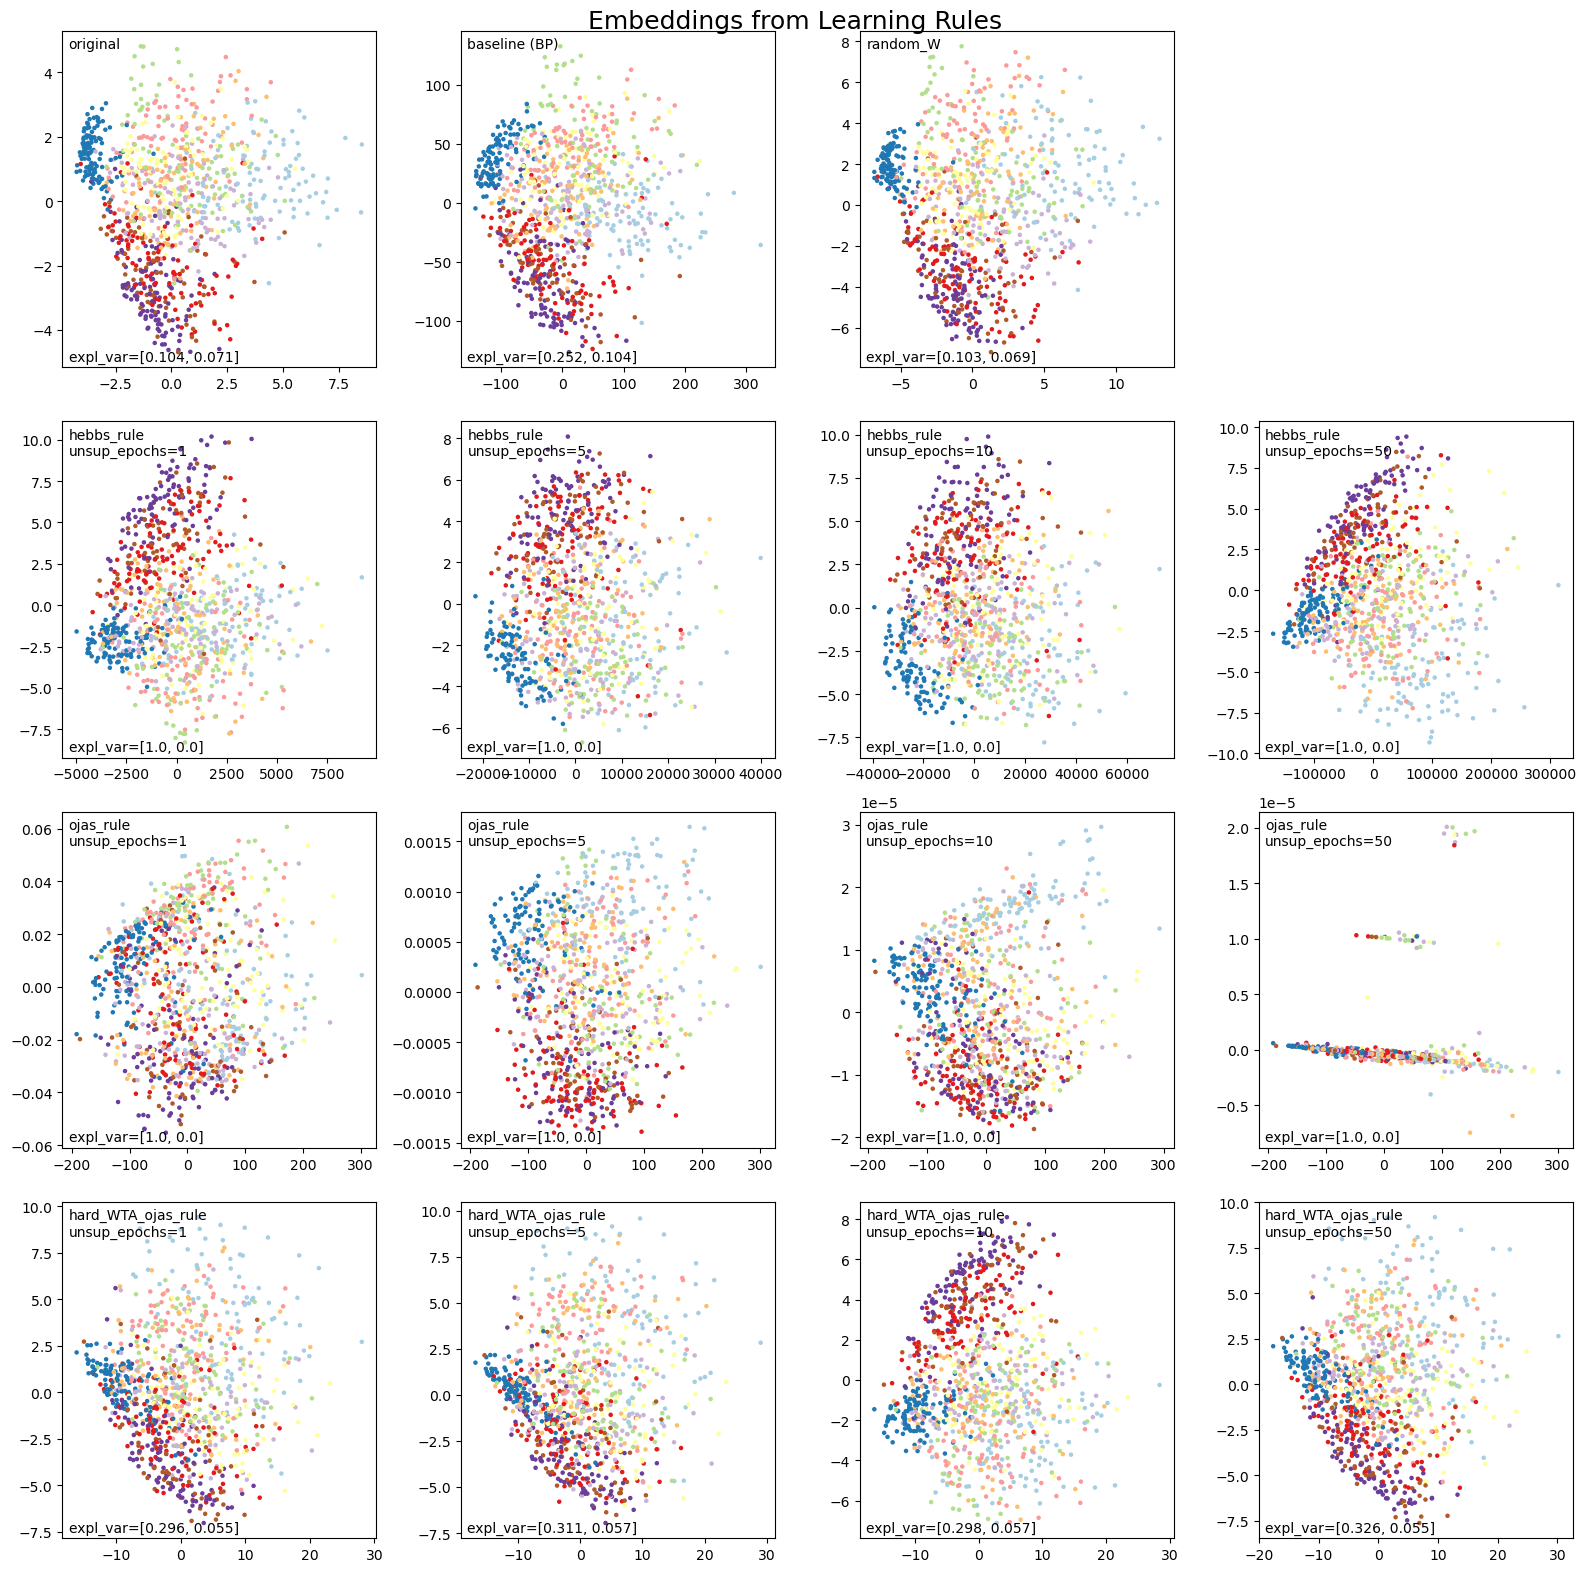

In [748]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# plot for original and baselines
axes[0, 0].scatter(x_proj[:, 0], x_proj[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 1].scatter(baseline_proj[:, 0], baseline_proj[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 2].scatter(random_W_proj[:, 0], random_W_proj[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 0].text(0.02, 0.95, 'original', transform=axes[0, 0].transAxes)
axes[0, 1].text(0.02, 0.95, 'baseline (BP)', transform=axes[0, 1].transAxes)
axes[0, 2].text(0.02, 0.95, 'random_W', transform=axes[0, 2].transAxes)
axes[0, 0].text(0.02, 0.02, f'expl_var={x_expl_var}', transform=axes[0, 0].transAxes)
axes[0, 1].text(0.02, 0.02, f'expl_var={baseline_expl_var}', transform=axes[0, 1].transAxes)
axes[0, 2].text(0.02, 0.02, f'expl_var={random_W_expl_var}', transform=axes[0, 2].transAxes)
axes[0, 3].axis('off')

# plot for Hebbian learning rules
for i, learning_rule in [(1, 'hebbs_rule'), (2, 'ojas_rule'), (3, 'hard_WTA_ojas_rule')]:
    for j, unsup_epochs in [(0, 1), (1, 5), (2, 10), (3, 50)]:
        ax = axes[i, j]
        proj_embedding = proj_embeddings[f'{learning_rule}-{unsup_epochs}']
        expl_var = expl_vars[f'{learning_rule}-{unsup_epochs}']
        ax.scatter(proj_embedding[:,0], proj_embedding[:,1], c=labels, cmap='Paired', s=5)
        ax.text(0.02, 0.9, f'{learning_rule}\nunsup_epochs={unsup_epochs}', transform=ax.transAxes)
        ax.text(0.02, 0.02, f'expl_var={expl_var}', transform=ax.transAxes)

# formatting
fig.suptitle('Embeddings from Learning Rules', fontsize=18)
plt.tight_layout()
fig.savefig('figures/embeddings.png', dpi=300)

### Unsup neuron cosine similarities

In [741]:
def get_neuron_similarities(model, num_samples=1000):
    # get and normalize weight matrix
    try:
        W = model.unsup_layer.W
    except:
        W = model.input.weight
    W_normed = F.normalize(W)
    
    # get pairwise cosine similarities
    similarities = torch.matmul(W_normed, W_normed.T)
    similarities = similarities[~torch.eye(similarities.size(0), dtype=bool)].flatten().detach()
    
    # sample similarities
    indices = torch.randperm(similarities.size(0))[:num_samples]
    similarities_sample = similarities[indices].numpy()

    return similarities_sample

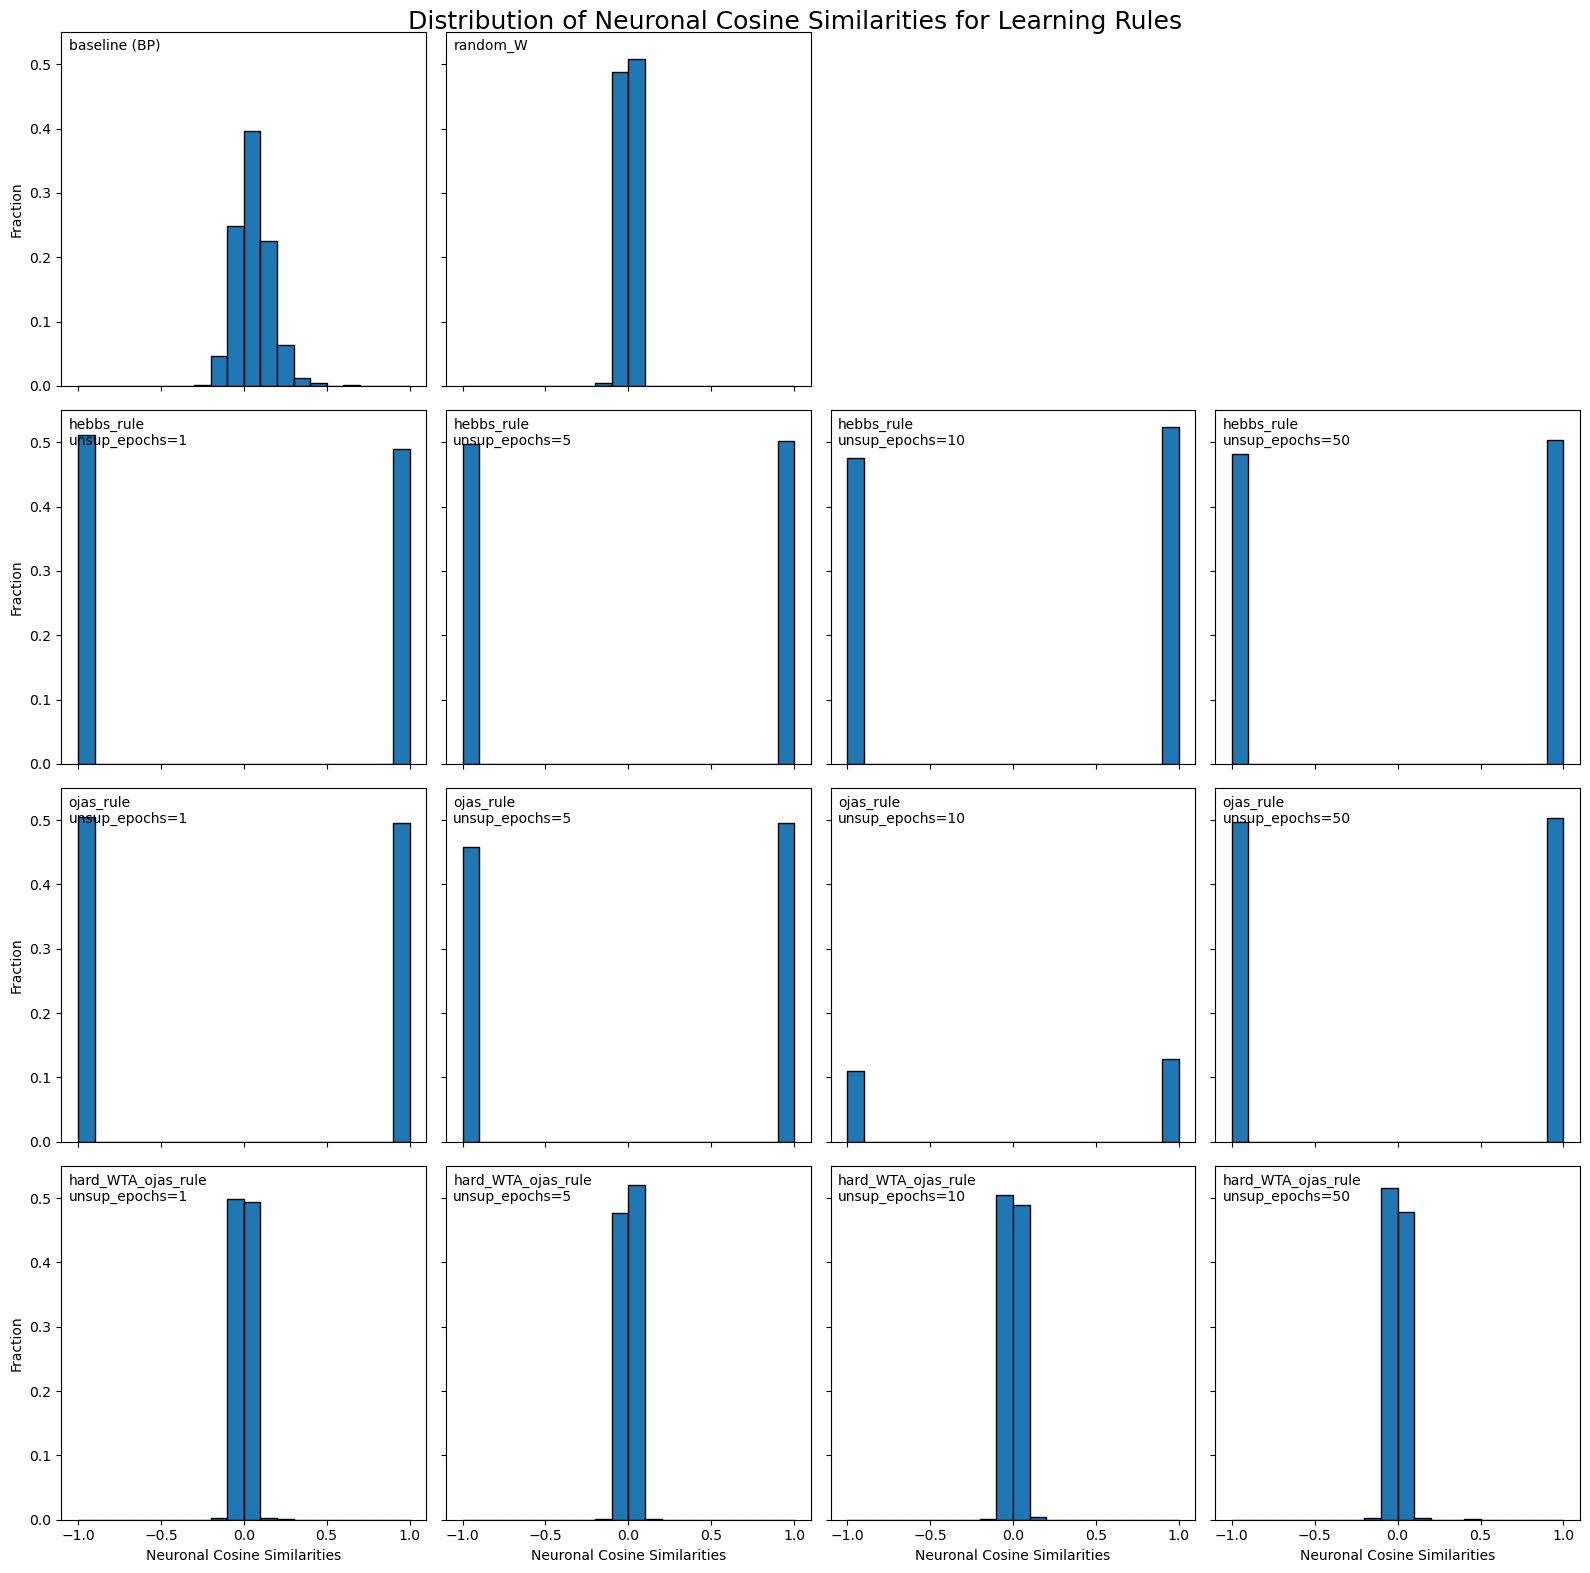

In [749]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)

# plot for baselines
axes[0, 0].hist(get_neuron_similarities(baseline), bins=20, range=(-1,1), weights=np.ones(num_samples)/num_samples, edgecolor='black')
axes[0, 1].hist(get_neuron_similarities(random_W), bins=20, range=(-1,1), weights=np.ones(num_samples)/num_samples, edgecolor='black')
axes[0, 0].text(0.02, 0.95, 'baseline (BP)', transform=axes[0, 0].transAxes)
axes[0, 1].text(0.02, 0.95, 'random_W', transform=axes[0, 1].transAxes)
axes[0, 2].axis('off')
axes[0, 3].axis('off')

# plot for Hebbian learning rules
for i, learning_rule in [(1, 'hebbs_rule'), (2, 'ojas_rule'), (3, 'hard_WTA_ojas_rule')]:
    for j, unsup_epochs in [(0, 1), (1, 5), (2, 10), (3, 50)]:
        ax = axes[i, j]
        model = load_model(learning_rule=learning_rule, unsup_epochs=unsup_epochs)
        ax.hist(get_neuron_similarities(model), bins=20, range=(-1,1), weights=np.ones(num_samples)/num_samples, edgecolor='black')
        ax.text(0.02, 0.9, f'{learning_rule}\nunsup_epochs={unsup_epochs}', transform=ax.transAxes)

# formatting
fig.suptitle('Distribution of Neuronal Cosine Similarities for Learning Rules', fontsize=18)
for j in range(4):
    axes[3, j].set_xlabel('Neuronal Cosine Similarities')
for i in range(4):
    axes[i, 0].set_ylabel('Fraction')
plt.tight_layout()
fig.savefig('figures/neuronal-similarities.png', dpi=300)

### Unsup synaptic activations in training

In [975]:
for W in weights:
    print(W[0])

In [976]:
dW = torch.tensor([0, 1, 3])

In [978]:
torch.nonzero(dW, 1)

TypeError: nonzero() takes 1 positional argument but 2 were given

In [973]:
n_neurons=100
weights = []
learning_rule = 'hard_WTA_ojas_rule'
for epoch in range(1, 51):
    model = load_model(learning_rule=learning_rule, mid_training=True, epoch=epoch)
    weights.append(model.unsup_layer.W.flatten().detach().numpy()[:784*n_neurons])

plt.figure(figsize=(20, 5), dpi=300)
plt.pcolormesh(weights, cmap='Oranges')
for n in range(1, n_neurons):
    plt.axvline(n*784, c='cyan')
plt.colorbar()
plt.title("Ojas's Rule")
plt.tight_layout()
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/hebbian/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_2187/1648119173.py", line 5, in <module>
    model = load_model(learning_rule=learning_rule, mid_training=True, epoch=epoch)
  File "/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_2187/4284482658.py", line 9, in load_model
    model = GenHebb(28*28, 2000, 10, learning_rule)
  File "/Users/cutterdawes/Desktop/MPI/HebbianLearning/genhebb.py", line 72, in __init__
    self.unsup_layer = HebbianLayer(input_dim, hidden_dim, plasticity, wta, **kwargs)
  File "/Users/cutterdawes/Desktop/MPI/HebbianLearning/genhebb.py", line 34, in __init__
    self.learning_rule = LearningRule(plasticity, wta, **kwargs)
  File "/Users/cutterdawes/Desktop/MPI/HebbianLearning/learning_rules.py", line 100, in __init__
    self.